## Configurações iniciais
Para clonar o repositório, utilize o seguinte comando:

In [ ]:
!git clone https://github.com/UFMG-Finance-Club/analyzeBRfunds.git

# Iniciando código

## DataDownload

O módulo DataDownload fornece utilitários para download de dados de fundos da Anbima, IBOVESPA e Risk-Free (obtido do NEFIN). 

### Download de fundos
Para o download de fundos, é necessário especificar os anos e meses iniciais e finais, além do diretório em que os arquivos serão gravados. Os dados são obtidos diretamente da [página da CVM](http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/), e nenhuma transformação é aplicada.

No código abaixo, baixamos dados referentes aos anos de 2017 a 2021:



In [5]:
from analyzeBRfunds import DataDownload

In [ ]:
(
    DataDownload.download_funds(
        first_date=[2017, 1], last_date=[2022, 1], 
        outpath="data/raw"
    )
)

## DataClean

Com o módulo DataClean podemos aplicar alguns tratamentos na base de fundos, e reduzi-los através de determinados critérios.

No exemplo abaixo, vamos considerar dois deles:

1. **Merge**: podemos reduzir o universo de fundos das bases a um subconjunto especificado em um arquivo *fundos.csv* que contém uma coluna **CNPJ_FUNDO** com seus respectivos CNPJs (que devem estar apenas com caracteres numéricos).
2. **Filter**: podemos aplicar filtros intervalares nos dados. Cada filtro é uma entrada de um dicionário Python. No exemplo abaixo, dizemos que queremos fundos em que a variável *DT_COMPTC* (data) apareça entre ["2018-01-03", "2018-01-03"], ou seja, estamos mantendo apenas fundos que tenham estado em atividade no dia 03/01/2018. 

Todas essas transformações podem ser aplicadas de uma só vez usando a função **format_new_data**.


In [3]:
from analyzeBRfunds import DataClean

In [50]:
(
    DataClean.Preprocess(inpath="data/raw")
    .format_new_data(
        outpath="data/preprocessed/2017_2021.csv",
        inrange_filters=[{"DT_COMPTC" : ["2018-01-03", "2018-01-03"]}],
        CNPJ_to_keep_path="data/auxiliary/fundos.csv", sep=";"
    )
)

Essas transformações também podem ser aplicadas separadamente e em momentos posteriores. No exemplo abaixo, leremos a base de novo e aplicaremos um segundo filtro: queremos apenas os fundos em que no dia 03/01/2020 (**DT_COMPTC**) o número de cotistas (**NR_COTST**) tenha sido maior do que 250. Como a base já foi tratada inicialmente, colocaremos o valor *existing* para o argumento *type*.

In [13]:
import numpy as np

prep_obj = (
    DataClean.Preprocess(inpath="data/preprocess/2017_2021.csv", type="existing")
    .apply_filters([{"DT_COMPTC" : ["2020-01-03", "2020-01-03"], "NR_COTST" : [250, np.inf]}])
)

O dado gerado pode ser acessado através do atributo *data*:

In [14]:
prep_obj.data

,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST,NOME_FUNDO
npartitions=1,,,,,,,,,
,object,object,float64,float64,float64,float64,float64,float64,object
,...,...,...,...,...,...,...,...,...


Note que é retornado um Dask DataFrame, que é *lazy*. Para visualizar os dados, i.e., computá-los, aplique o método *compute*:

In [15]:
prep_obj.data.compute()

,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST,NOME_FUNDO
0,17397804000179,2017-02-01,5.736429e+07,1.612580,5.741913e+07,21033.32,0.00,55.0,Apex Infinity 8 Long Biased Fc FIA
1,17397804000179,2017-02-02,1.648277e+08,1.615899,1.642899e+08,0.00,0.00,174.0,Apex Infinity 8 Long Biased Fc FIA
2,17397804000179,2017-02-03,1.676777e+08,1.631688,1.658952e+08,0.00,0.00,174.0,Apex Infinity 8 Long Biased Fc FIA
3,17397804000179,2017-02-06,1.655593e+08,1.621880,1.649049e+08,1087500.00,0.00,173.0,Apex Infinity 8 Long Biased Fc FIA
4,17397804000179,2017-02-07,1.658283e+08,1.620471,1.647766e+08,15000.00,0.00,173.0,Apex Infinity 8 Long Biased Fc FIA
...,...,...,...,...,...,...,...,...,...
270048,09087483000188,2020-09-24,3.902144e+07,2.339143,3.999969e+07,0.00,64216.55,273.0,Wa Dividend Yield FIA
270049,09087483000188,2020-09-25,3.889399e+07,2.330183,3.983260e+07,0.00,13882.57,272.0,Wa Dividend Yield FIA
270050,09087483000188,2020-09-28,3.815633e+07,2.275232,3.881881e+07,1074.00,75514.69,271.0,Wa Dividend Yield FIA
270051,09087483000188,2020-09-29,3.771789e+07,2.250453,3.838186e+07,0.00,14181.91,270.0,Wa Dividend Yield FIA


Naturalmente, também podemos escrevê-lo em algum arquivo:

In [16]:
prep_obj.write(outpath="data/preprocess/2017_2021.csv")

## Analisando performance

Com o utilitário FinancialMetrics podemos facilmente obter retornos e estimar alfas e betas.

In [3]:
#from analyzeBRfunds import FinancialMetrics
import FinancialMetrics

fin_metrics = (
    FinancialMetrics.PerformanceMetrics(
        inpath="data/preprocessed/2017_2021.csv",
        first_date=[2017,1,1], last_date=[2021,12,30]
    )
)

Podemos obter retornos através do atributo **returns_data**:

In [38]:
fin_metrics.returns_data

Name,00398561000190,00601692000123,01063897000165,01608399000150,01753087000130,01776200000101,02097252000106,02138442000124,02436763000105,02763602000126,...,28470587000111,28747685000153,29544764000120,47178215000160,67845909000111,68670512000107,73232530000139,88198056000143,96498654000166,97261093000140
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,0.032493,0.034971,0.023578,0.027739,0.022910,0.021858,0.028036,0.037555,0.027328,0.023744,...,NaN,NaN,0.008381,0.034783,0.028420,0.040802,0.026882,0.013670,0.034168,0.036420
2017-01-04,0.001256,0.009899,0.001565,0.001383,0.002018,-0.018023,0.004036,-0.001286,0.000941,0.002677,...,NaN,NaN,0.001907,0.002915,0.002911,-0.007620,0.000842,0.004258,0.004874,-0.001109
2017-01-05,0.005794,0.008281,0.006212,0.005772,0.005091,-0.000387,-0.001154,0.000600,0.004513,0.009256,...,NaN,NaN,-0.002160,0.003370,0.006041,0.027502,0.000920,0.000545,0.011639,0.009598
2017-01-06,-0.005651,-0.003877,-0.005047,-0.003469,-0.002641,-0.009347,-0.005232,-0.003984,-0.005545,-0.006710,...,NaN,NaN,-0.001751,-0.006363,-0.005990,-0.028696,-0.004096,-0.002480,-0.004501,-0.009141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,-0.000081,-0.000080,-0.000065,-0.000124,-0.000073,-0.000078,-0.000063,-0.000044,-0.000097,-0.000095,...,-0.000059,-0.000110,-0.000042,-0.000176,-0.000195,0.000013,-0.000142,-0.000197,-0.000134,-0.000101
2021-12-27,0.008699,0.006268,0.011006,0.007152,0.008209,0.005040,0.008625,0.008003,0.007001,0.010555,...,0.004387,0.005411,0.008299,0.008194,0.005680,0.009192,0.007050,0.007553,0.006366,0.010959
2021-12-28,0.001663,-0.004477,0.004556,-0.006899,-0.006364,-0.000307,-0.000248,0.000305,-0.008542,0.008022,...,-0.006403,-0.004830,-0.003784,-0.000055,-0.004044,-0.000577,-0.008843,0.004998,-0.004693,-0.004812


Por padrão, o CNPJ é usado como identificador do fundo, mas isso pode ser alterado:

In [59]:
fin_metrics = (
    FinancialMetrics.PerformanceMetrics(
        inpath="data/preprocessed/2017_2021.csv",
        id_col="NOME_FUNDO", first_date=[2018,1,1], last_date=[2021,12,30]
    )
)

Utilizando os dados de retorno para obter os 5 fundos que melhor perfomaram durante o período de dados:

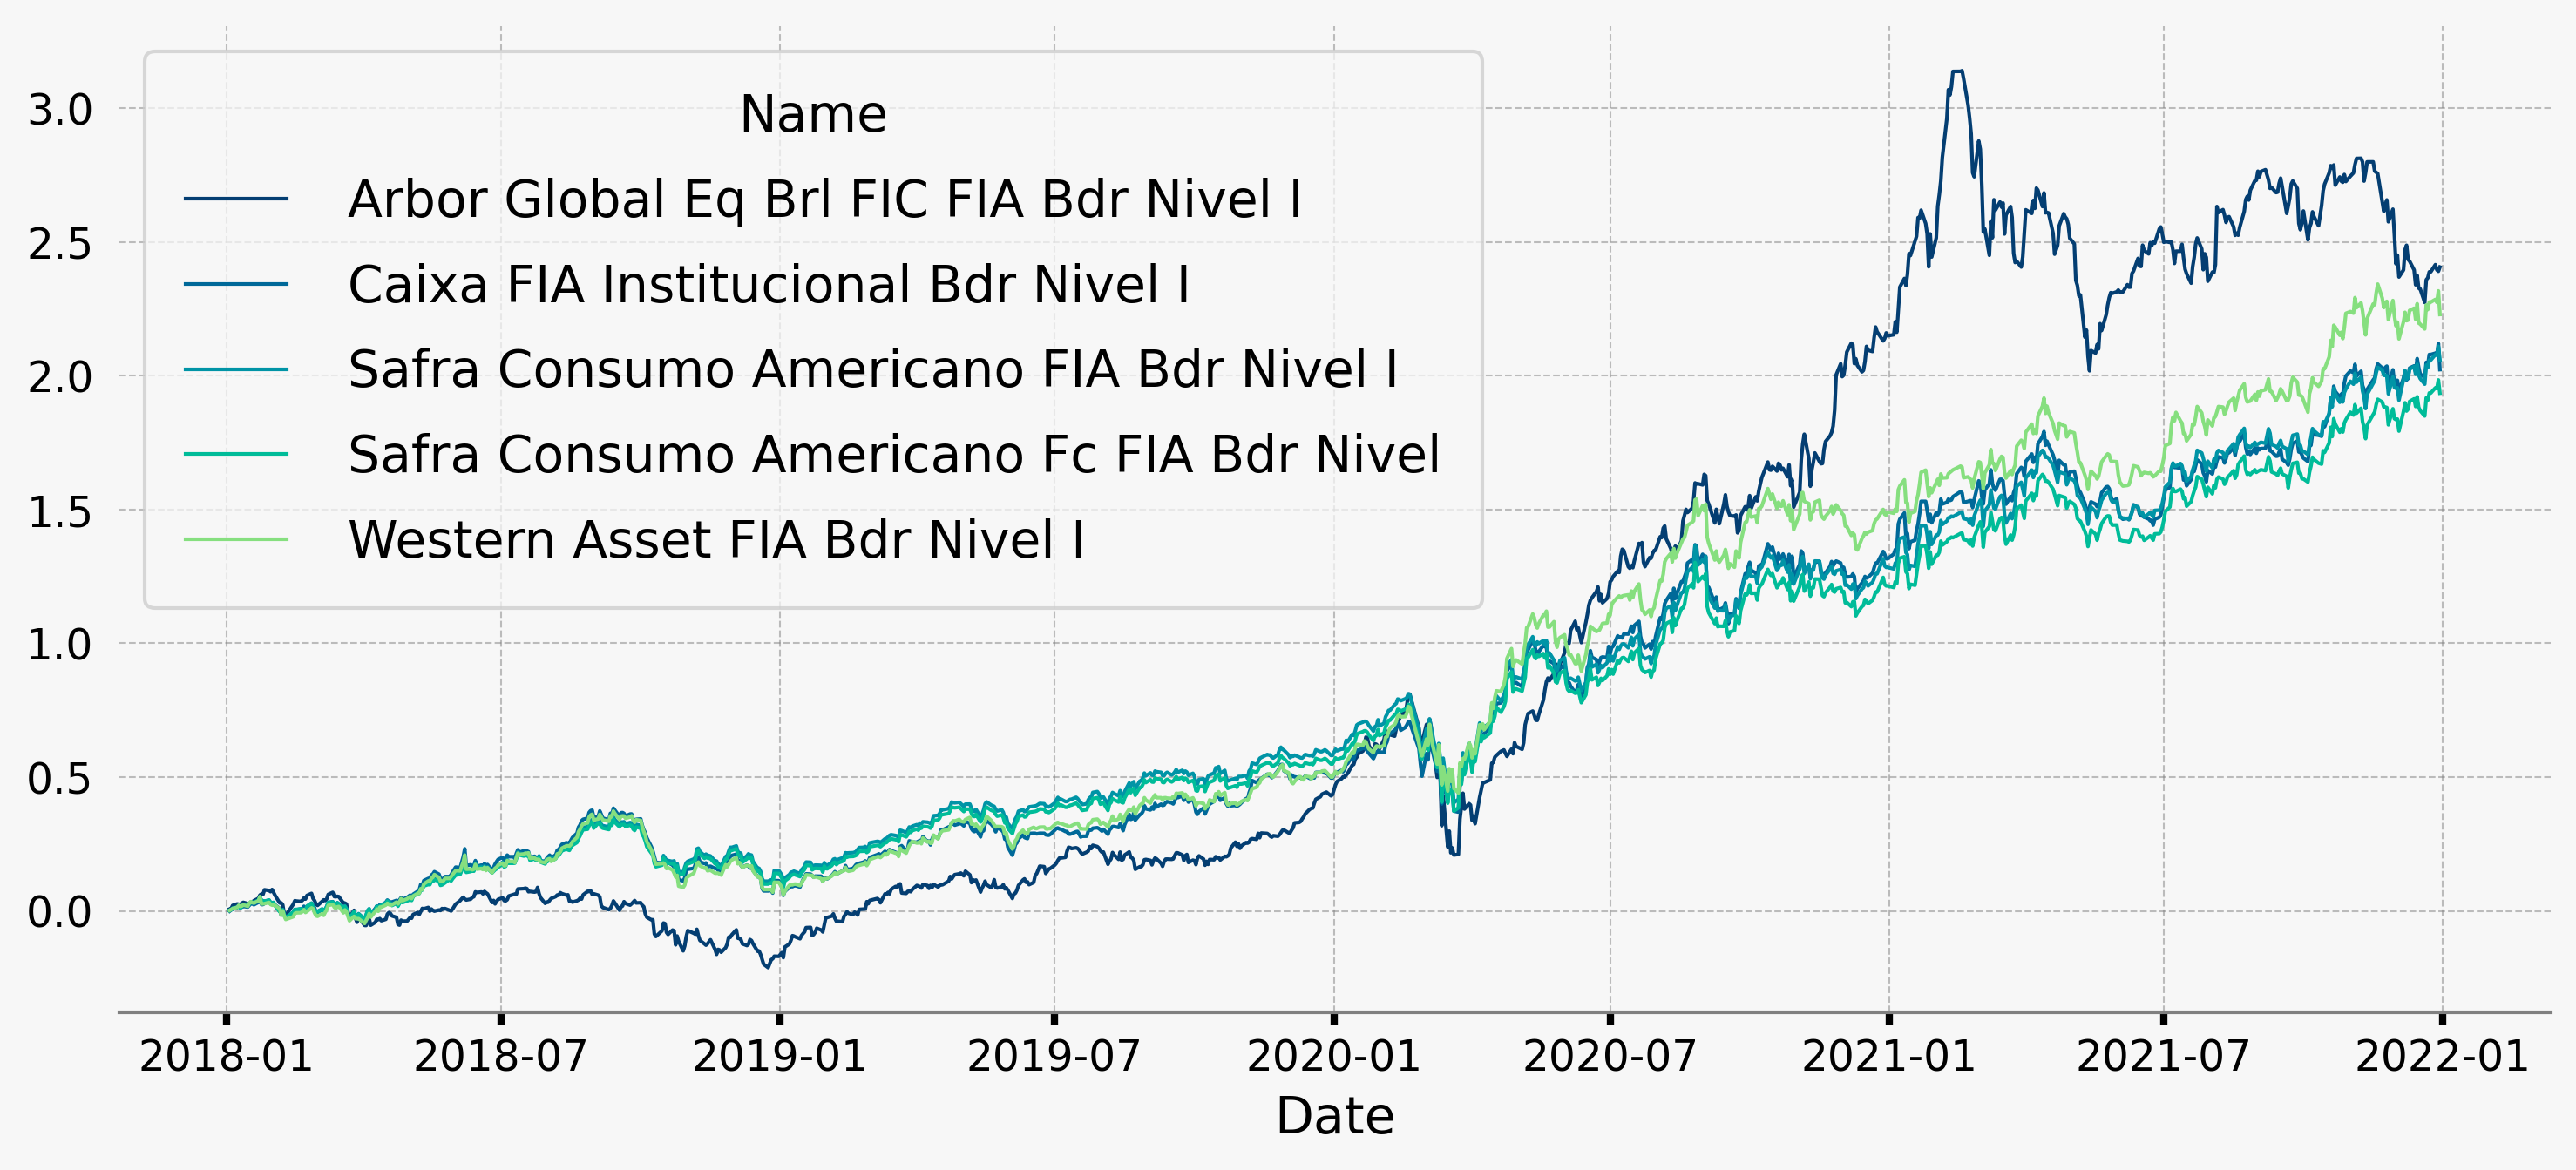

In [7]:
import matplotlib.pyplot as plt
plt.style.use("finance_theme.mplstyle")

cumulative_returns = fin_metrics.cumulative_returns_data
funds_to_plot = (
    cumulative_returns
    .iloc[-1]
    .sort_values(ascending=False)
)

cumulative_returns.loc[:, cumulative_returns.columns.isin(funds_to_plot.iloc[:5].index)].plot()
plt.show()

Podemos incrementar os dados com os preços de fechamento (ajustados) do IBOV (obtido através do Yahoo Finance) e a taxa livre de risco diária (obtida do NEFIN: 30-day DI Swap). 

In [60]:
fin_metrics.increment_with("IBOV")
fin_metrics.increment_with("RISK_FREE", outpath_base="data/auxiliary/risk_free.csv")

E que tal olharmos algums métricas, como desvio-padrão, drawdown máximo e Sharpe?

In [25]:
fin_metrics.metrics_data

,std,annualized_std,cumulative_ret,annualized_ret,max_drawdown,Sharpe
Name,,,,,,
4um Marlin Dividendos FIA,0.014108,0.223965,0.419053,0.091916,0.757752,0.415070
4um Small Caps FIA,0.014502,0.230216,0.694548,0.141692,0.721376,0.620017
ARX Income Fc FIA,0.017103,0.271496,0.657495,0.135368,0.800858,0.502450
ARX Long Term Fc FIA,0.017922,0.284511,0.266135,0.061079,0.920523,0.218356
Af Invest Minas FIA,0.016262,0.258147,0.742961,0.149801,0.784455,0.584343
...,...,...,...,...,...,...
Xp Investor 30 FIC FIA,0.018276,0.290124,0.454323,0.098672,1.114557,0.343705
Xp Investor Dividendos 30 Fc FIA,0.016023,0.254352,0.267383,0.061342,0.807498,0.245279
Xp Investor Dividendos FIA,0.016401,0.260364,0.279970,0.063980,0.825696,0.249749


Por fim, no exemplo abaixo, vamos estimar os alfas e betas dos fundos, usando como base os dados do IBOV e da taxa livre de risco obtidos anteriormente, com parâmetros estimados via OLS (ordinary Least Squares), e num conjunto restrito de fundos (apenas o top 10% de melhor retorno no período considerado)

In [61]:
from math import floor

funds_to_estimate = funds_to_plot.iloc[:floor(.1 * len(funds_to_plot))].index.values

In [62]:
fin_metrics.estimate_factors(selected=list(funds_to_estimate))

,Fund,Alpha,Beta,R_squared,Pvalue
0,Arbor Global Eq Brl FIC FIA Bdr Nivel I,0.000967,0.675349,0.494865,1.286761e-150
1,Western Asset FIA Bdr Nivel I,0.000896,0.364095,0.229778,9.348881e-59
2,Safra Consumo Americano FIA Bdr Nivel I,0.000843,0.404635,0.273407,1.812243e-71
3,Caixa FIA Institucional Bdr Nivel I,0.000836,0.337750,0.197010,1.148173e-49
4,Safra Consumo Americano Fc FIA Bdr Nivel,0.000801,0.404398,0.273371,1.858222e-71
5,Caixa FIA Bdr Nivel I,0.000799,0.336666,0.197359,9.231526e-50
6,Safra FIA Bdr Nivel I Pb,0.000756,0.417324,0.296037,2.310105e-78
7,BB Acoes Esg Globais Fc FIA -Bdr Nivel I,0.000763,0.326745,0.186289,9.017942e-47
8,Csn Invest Fdo de Investimento em Acoes,0.000932,1.023620,0.482162,3.262982e-145
9,Safra Fc FIA Bdr Nivel I,0.000713,0.417036,0.296090,2.224917e-78
